# CartPole 問題

- **CartPole**:
    - [OpenAI Gym](https://gym.openai.com/) が提供しているゲーム環境の一つで [倒立振子](https://ja.wikipedia.org/wiki/%E5%80%92%E7%AB%8B%E6%8C%AF%E5%AD%90) に関するゲーム
    - 台車の上に回転軸が固定された棒を立て、台車を左右に動かすことによって棒が倒れないように制御する問題

## Resources

- [倒立振子](http://maicommon.ciao.jp/ss/phisic/RevPend/index.htm)
- [RLEnv.CartPole](https://github.com/JuliaReinforcementLearning/ReinforcementLearning.jl/blob/master/src/ReinforcementLearningEnvironments/src/environments/examples/CartPoleEnv.jl)
- [CartPole Plots](https://github.com/JuliaReinforcementLearning/ReinforcementLearning.jl/issues/246#issuecomment-846903183)

In [84]:
# CartPole 環境
Base.@kwdef mutable struct CartPoleEnv
    cart_pos::Number = 0.0   # 台車位置: -2.4 ~ +2.4
    cart_acc::Number = 0.0   # 台車加速度: -Inf ~ +Inf
    pole_theta::Number = 0.0 # 棒の角度θ: (-41.8° ~ +41.8°) * 2π / 180
    pole_acc::Number = 0.0   # 棒の先端の加速度: -Inf ~ +Inf
    step::Int = 0            # ステップ数: 0 ~ +Inf (=報酬)

    # 環境変数（固定値）
    params = (
        gravity = 9.8,                           # 重力加速度
        cart_mass = 1.0,                         # 台車の重さ
        pole_mass = 0.1,                         # 棒の重さ
        pole_center_length = 0.5,                # 棒の半分の長さ
        force = 10.0,                            # 台車を動かす際の運動量
        dt = 0.02,                               # 時間変化量: 0.02 => 50ステップで1秒
        pole_theta_threshold = 12.0 * 2pi / 180, # ゲーム終了条件となる棒の角度のしきい値θ: ±12° * 2π / 180
        cart_pos_threshold = 2.4,                # ゲーム終了条件となる台車位置のしきい値: ±2.4
        max_steps = 200,                         # ゲーム終了条件となる最大ステップ数: 200
    )
end

# CartPole 行動
cartpole_action = (
    Val(-1), # 台車を左に押す
    Val(0),  # 台車を押さない
    Val(+1), # 台車を右に押す
)

# CartPole 終了条件
is_terminated(env::CartPoleEnv) =
    abs(env.pole_theta) > env.params.pole_theta_threshold ||
    abs(env.cart_pos) > env.params.cart_pos_threshold ||
    env.step > env.params.max_steps

value(::Val{T}) where T = T

# CartPole 1ステップでの物理演算
# `action::Union{Val{-1}, Val{0}, Val{+1}}`: 台車を動かす方向
step!(env::CartPoleEnv, action::Union{Val{-1}, Val{0}, Val{+1}}) = begin
    env.step += 1
    force = value(action) * env.params.force
    costheta = cos(env.pole_theta)
    sintheta = sin(env.pole_theta)
    totalmass = env.params.cart_mass + env.params.pole_mass
    polemasslength = env.params.pole_mass * env.params.pole_center_length
    tmp = (force + polemasslength * env.pole_theta^2 * sintheta) / totalmass
    thetaacc =
        (env.params.gravity * sintheta - costheta * tmp) / (
            env.params.pole_center_length *
            (4 / 3 - env.params.pole_mass * costheta^2 / totalmass)
        )
    xacc = tmp - polemasslength * thetaacc * costheta / totalmass
    env.cart_pos += env.params.dt * env.cart_pos
    env.cart_acc += env.params.dt * xacc
    env.pole_theta += env.params.dt * env.pole_theta
    env.pole_acc += env.params.dt * env.pole_acc
    nothing
end

step! (generic function with 1 method)

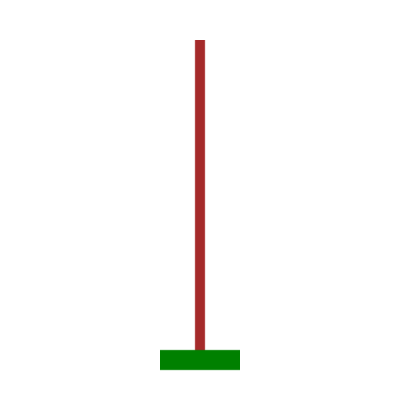

In [1]:
"""
Makie.jl による CartPole 描画
"""

using GLMakie

scene = Scene(resolution = (400, 400))

# 棒
lines!(
    scene,
    [0, 0],
    [0.8, -0.8],
    color = :brown,
    linewidth = 10
)

# 台車
lines!(
    scene,
    [-0.2, 0.2],
    [-0.8, -0.8],
    color = :green,
    linewidth = 20
)

scene

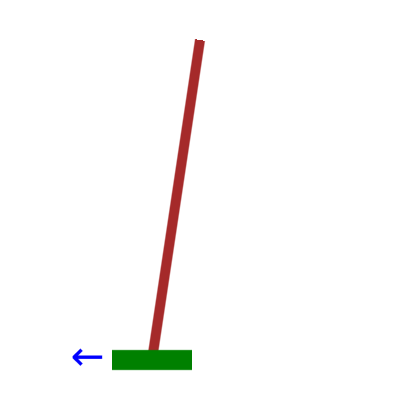

In [56]:
"""
台車位置が -2.4 になった場合の CartPole 描画
"""

scene = Scene(resolution = (400, 400))
pos = -2.4 * 0.1 # ×0.1: グラフ内描画位置調整変数

# 棒
lines!(
    scene,
    [0, pos],
    [0.8, -0.8],
    color = :brown,
    linewidth = 10
)

# 台車
lines!(
    scene,
    [pos - 0.2, pos + 0.2],
    [-0.8, -0.8],
    color = :green,
    linewidth = 20
)

# 運動量ベクトル
text!(
    scene,
    "←",
    position = (pos - 0.4, -0.8 - 0.1),
    color = :blue,
    textsize = 40
)

scene

In [70]:
plot(env::CartPoleEnv, action::Union{Val{-1}, Val{0}, Val{+1}}) = begin
    scene = Scene(resolution = (400, 400))
    pos = env.cart_pos * 0.1 # ×0.1: グラフ内描画位置調整変数

    # 棒
    lines!(
        scene,
        [0, pos],
        [0.8, -0.8],
        color = :brown,
        linewidth = 10
    )

    # 台車
    lines!(
        scene,
        [pos - 0.2, pos + 0.2],
        [-0.8, -0.8],
        color = :green,
        linewidth = 20
    )

    # 運動量ベクトル
    a = value(action)
    if a !== 0
        text!(
            scene,
            a === -1 ? "←" : "→",
            position = (pos + 0.4a, -0.8 - 0.1),
            color = :blue,
            textsize = 40
        )
    end

    scene
end

plot (generic function with 1 method)

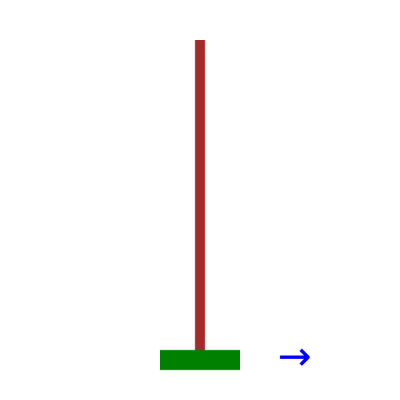

In [71]:
env = CartPoleEnv()

step!(env, Val(1))
plot(env, Val(1))

In [101]:
plot(env, Val(1)).plots

3-element Vector{AbstractPlot}:
 Lines{Tuple{Vector{Point{2, Float32}}}}
 Lines{Tuple{Vector{Point{2, Float32}}}}
 MakieCore.Text{Tuple{String}}

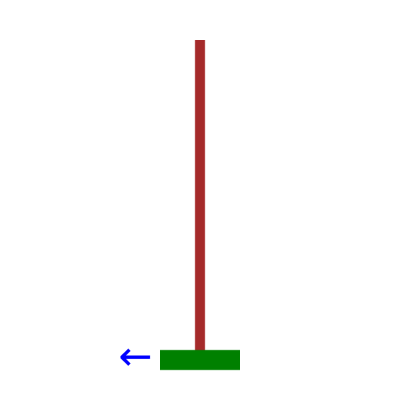

In [119]:
env = CartPoleEnv()

scene = Scene(resolution = (400, 400))
recordscene = Observable(plot(env, Val(0)))
push!(scene.children, recordscene[])

record(scene, "04-cartpole-test.gif", framerate = 30) do io
    while !is_terminated(env)
        action = rand((Val(-1), Val(+1)))
        step!(env, action)
        recordscene[] = plot(env, action)
        scene.children[1] = recordscene[]
        recordframe!(io)
    end
end

scene